In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [4]:
train = pd.read_parquet("train.parquet")
test = pd.read_parquet("test.parquet")

train.shape, test.shape

((17499636, 19), (4393179, 19))

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17499636 entries, 0 to 25661583
Data columns (total 19 columns):
 #   Column         Dtype         
---  ------         -----         
 0   status         int64         
 1   gender         object        
 2   firstName      object        
 3   level          object        
 4   lastName       object        
 5   userId         object        
 6   ts             int64         
 7   auth           object        
 8   page           object        
 9   sessionId      int64         
 10  location       object        
 11  itemInSession  int64         
 12  userAgent      object        
 13  method         object        
 14  length         float64       
 15  song           object        
 16  artist         object        
 17  time           datetime64[us]
 18  registration   datetime64[us]
dtypes: datetime64[us](2), float64(1), int64(4), object(12)
memory usage: 2.6+ GB


In [6]:
train.head()

,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,method,length,song,artist,time,registration
0,200,M,Shlok,paid,Johnson,1749042,1538352001000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",278,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,524.32934,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,2018-10-01 00:00:01,2018-08-08 13:22:21
992,200,M,Shlok,paid,Johnson,1749042,1538352525000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",279,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,178.02404,Monster (Album Version),Skillet,2018-10-01 00:08:45,2018-08-08 13:22:21
1360,200,M,Shlok,paid,Johnson,1749042,1538352703000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",280,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,232.61995,Seven Nation Army,The White Stripes,2018-10-01 00:11:43,2018-08-08 13:22:21
1825,200,M,Shlok,paid,Johnson,1749042,1538352935000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",281,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,265.50812,Under The Bridge (Album Version),Red Hot Chili Peppers,2018-10-01 00:15:35,2018-08-08 13:22:21
2366,200,M,Shlok,paid,Johnson,1749042,1538353200000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",282,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,471.69261,Circlesong 6,Bobby McFerrin,2018-10-01 00:20:00,2018-08-08 13:22:21


In [7]:
sub = pd.read_csv("example_submission.csv")

### Y-variable

In [8]:
train['page'].unique()

array(['NextSong', 'Downgrade', 'Help', 'Home', 'Thumbs Up', 'Add Friend',
       'Thumbs Down', 'Add to Playlist', 'Logout', 'About', 'Settings',
       'Save Settings', 'Cancel', 'Cancellation Confirmation',
       'Submit Downgrade', 'Roll Advert', 'Upgrade', 'Error',
       'Submit Upgrade'], dtype=object)

In [9]:
test['page'].unique()

array(['NextSong', 'Roll Advert', 'Settings', 'Add to Playlist',
       'Thumbs Up', 'Home', 'Help', 'Logout', 'About', 'Upgrade',
       'Submit Upgrade', 'Thumbs Down', 'Downgrade', 'Add Friend',
       'Error', 'Save Settings', 'Submit Downgrade', 'Login', 'Register',
       'Submit Registration'], dtype=object)

In [10]:
train['page'].value_counts()

page
NextSong                     14291433
Thumbs Up                      789391
Home                           645259
Add to Playlist                409606
Roll Advert                    284837
Add Friend                     262147
Logout                         204700
Thumbs Down                    164964
Downgrade                      124248
Settings                       101191
Help                            89035
Upgrade                         37696
About                           33117
Save Settings                   20370
Error                           17294
Submit Upgrade                  11381
Submit Downgrade                 4425
Cancellation Confirmation        4271
Cancel                           4271
Name: count, dtype: int64

In [11]:
cancel_users = set(train.loc[train['page'] == "Cancel", 'userId'].unique())
churn_users = set(train.loc[train['page'] == "Cancellation Confirmation", 'userId'].unique())

len(cancel_users - churn_users), len(churn_users - cancel_users)

(0, 0)

In [12]:
(train['page'] == 'Cancellation Confirmation').mean()

0.00024406221935130537

In [13]:
# Per-user activity distribution
train.groupby("userId").size().describe()

count    19140.000000
mean       914.296552
std       1079.652218
min          1.000000
25%        202.000000
50%        537.500000
75%       1213.000000
max      10998.000000
dtype: float64

In [14]:
# Churn rate at user level
user_num = train['userId'].nunique()
cancellation_rate = len(churn_users) / user_num
cancellation_rate

0.22314524555903867

In [15]:
train['is_churn'] = train['userId'].isin(churn_users).astype(int)
train.groupby("is_churn")['page'].value_counts()

is_churn  page                     
0         NextSong                     11103777
          Thumbs Up                      626792
          Home                           500701
          Add to Playlist                318781
          Roll Advert                    207049
          Add Friend                     203968
          Logout                         158852
          Thumbs Down                    124141
          Downgrade                       92609
          Settings                        78058
          Help                            69028
          Upgrade                         29008
          About                           25840
          Save Settings                   15853
          Error                           13375
          Submit Upgrade                   8490
          Submit Downgrade                 3348
1         NextSong                      3187656
          Thumbs Up                      162599
          Home                           144558
    

### EDA - Page

#### Per-user page usage ratio

In [16]:
clean_train = train[~train['page'].isin(['Cancel', 'Cancellation Confirmation'])]
user_total = clean_train.groupby('userId').size().rename("total_events")
page_counts = clean_train.groupby(['userId', 'page']).size().unstack(fill_value=0)
page_ratio = page_counts.div(user_total, axis=0)
page_ratio['target'] = page_ratio.index.isin(churn_users).astype(int)
page_ratio.groupby("target").mean().T

target,0,1
page,,
About,0.002030,0.001846
Add Friend,0.015243,0.014602
Add to Playlist,0.022413,0.021925
Downgrade,0.004849,0.007740
Error,0.001019,0.001028
Help,0.005109,0.004878
Home,0.044687,0.041301
Logout,0.014928,0.012707
NextSong,0.792683,0.788946


#### Usage duration

In [17]:
user_last = train.groupby('userId')['time'].max()
user_reg = train.groupby('userId')['registration'].min()

# Account lifetime in days
duration = (user_last - user_reg).dt.days.rename("duration_days")
duration_df = duration.to_frame()
duration_df['target'] = duration_df.index.isin(churn_users).astype(int)
duration_df.groupby("target")['duration_days'].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,14869.0,77.952384,38.784001,0.0,53.0,68.0,93.0,399.0
1,4271.0,58.837041,40.369762,0.0,31.0,50.0,76.0,322.0


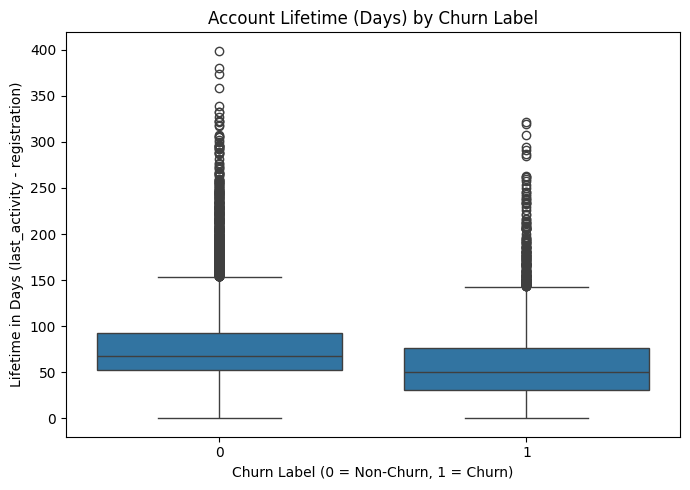

In [18]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=duration_df, x="target", y="duration_days")
plt.title("Account Lifetime (Days) by Churn Label")
plt.xlabel("Churn Label (0 = Non-Churn, 1 = Churn)")
plt.ylabel("Lifetime in Days (last_activity - registration)")
plt.tight_layout()
plt.show()


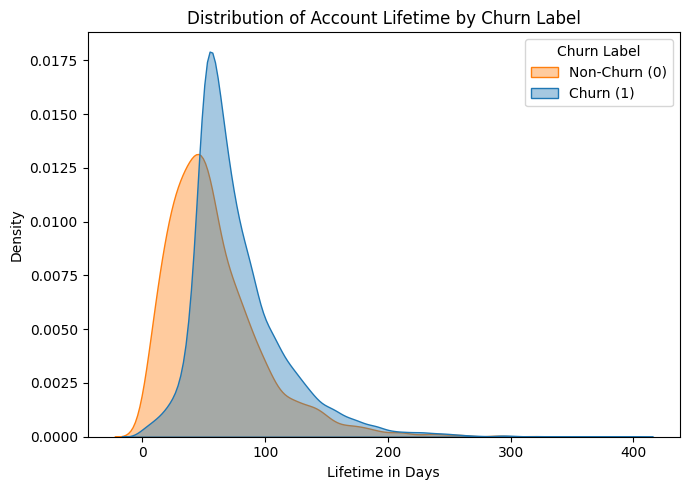

In [19]:
plt.figure(figsize=(7, 5))
sns.kdeplot(
    data=duration_df,
    x="duration_days",
    hue="target",
    common_norm=False,
    fill=True,
    alpha=0.4
)
plt.title("Distribution of Account Lifetime by Churn Label")
plt.xlabel("Lifetime in Days")
plt.ylabel("Density")
plt.legend(title="Churn Label", labels=["Non-Churn (0)", "Churn (1)"])
plt.tight_layout()
plt.show()


#### Session per user

In [20]:
sessions = train.groupby('userId')['sessionId'].nunique().rename("session_count")
sessions_df = sessions.to_frame()
sessions_df['target'] = sessions_df.index.isin(churn_users).astype(int)
sessions_df.groupby("target")['session_count'].describe()


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,14869.0,10.966911,10.673177,1.0,4.0,8.0,14.0,116.0
1,4271.0,10.604308,10.587710,1.0,3.0,7.0,14.0,92.0


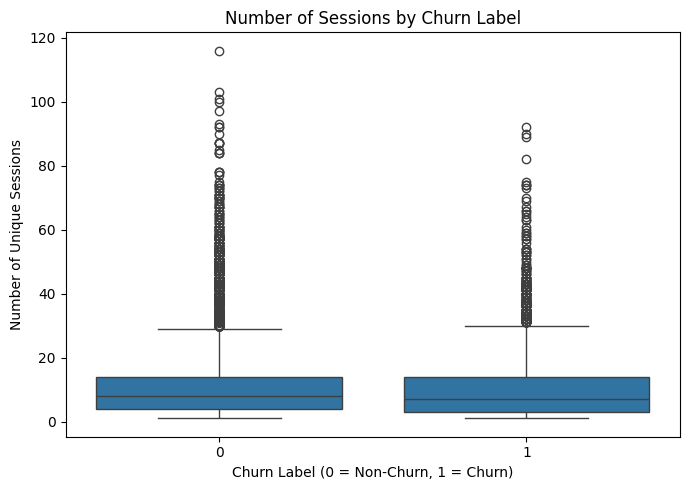

In [21]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=sessions_df, x="target", y="session_count")
plt.title("Number of Sessions by Churn Label")
plt.xlabel("Churn Label (0 = Non-Churn, 1 = Churn)")
plt.ylabel("Number of Unique Sessions")
plt.tight_layout()
plt.show()


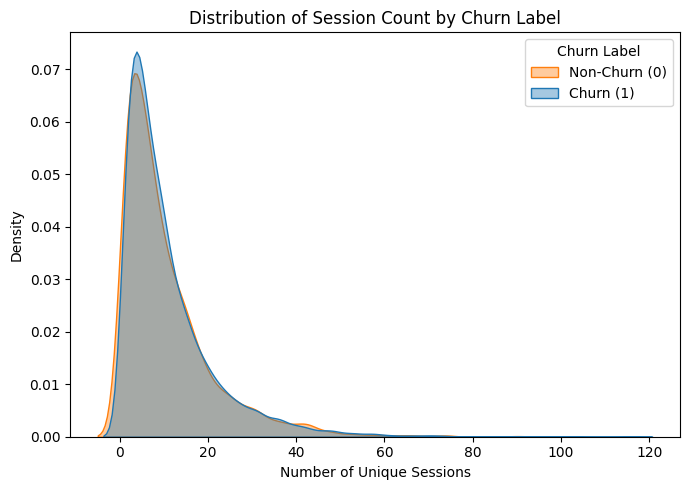

In [22]:
plt.figure(figsize=(7, 5))
sns.kdeplot(
    data=sessions_df,
    x="session_count",
    hue="target",
    common_norm=False,
    fill=True,
    alpha=0.4
)
plt.title("Distribution of Session Count by Churn Label")
plt.xlabel("Number of Unique Sessions")
plt.ylabel("Density")
plt.legend(title="Churn Label", labels=["Non-Churn (0)", "Churn (1)"])
plt.tight_layout()
plt.show()


In [23]:
page_means = page_ratio.groupby("target").mean()
page_diff = (page_means.loc[1] - page_means.loc[0]).sort_values(ascending=False)
page_diff

page
Roll Advert         0.009203
Downgrade           0.002892
Thumbs Down         0.002695
Settings            0.000972
Submit Upgrade      0.000330
Submit Downgrade    0.000063
Error               0.000009
Save Settings      -0.000069
Upgrade            -0.000121
About              -0.000184
Help               -0.000231
Add to Playlist    -0.000488
Add Friend         -0.000641
Logout             -0.002221
Home               -0.003386
NextSong           -0.003737
Thumbs Up          -0.005085
dtype: float64

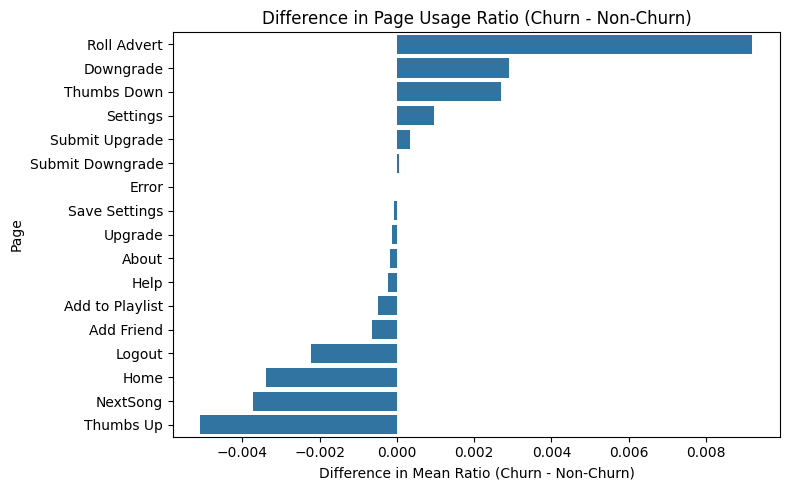

In [24]:
plt.figure(figsize=(8, 5))
sns.barplot(x=page_diff.values, y=page_diff.index)
plt.title("Difference in Page Usage Ratio (Churn - Non-Churn)")
plt.xlabel("Difference in Mean Ratio (Churn - Non-Churn)")
plt.ylabel("Page")
plt.tight_layout()
plt.show()

### Other features EDA

In [25]:
summary_list = []

for col in train.columns:
    nunique = train[col].nunique(dropna=False)
    dtype = train[col].dtype
    if nunique <= 20:
        uniq_vals = list(train[col].dropna().unique())
    else:
        uniq_vals = "Too many to display"
    summary_list.append({
        "column": col,
        "dtype": dtype,
        "n_unique": nunique,
        "unique_values": uniq_vals
    })

pd.DataFrame(summary_list)

,column,dtype,n_unique,unique_values
0,status,int64,3,"[200, 307, 404]"
1,gender,object,2,"[M, F]"
2,firstName,object,4967,Too many to display
3,level,object,2,"[paid, free]"
4,lastName,object,1000,Too many to display
5,userId,object,19140,Too many to display
6,ts,int64,4189091,Too many to display
7,auth,object,2,"[Logged In, Cancelled]"
8,page,object,19,"[NextSong, Downgrade, Help, Home, Thumbs Up, A..."
9,sessionId,int64,161194,Too many to display


#### Status

In [26]:
pd.crosstab(train['status'], train['is_churn'], normalize='index')

is_churn,0,1
status,,
200,0.775550,0.224450
307,0.780929,0.219071
404,0.773390,0.226610


#### Level

In [27]:
pd.crosstab(train['level'], train['is_churn'], normalize='index')

is_churn,0,1
level,,
free,0.766101,0.233899
paid,0.778923,0.221077


#### Auth

In [28]:
pd.crosstab(train['auth'], train['is_churn'], normalize='index')

is_churn,0,1
auth,,
Cancelled,0.000000,1.000000
Logged In,0.776187,0.223813


To prevent leakage this needs to be deleted in the train set

#### Method

In [29]:
pd.crosstab(train['method'], train['is_churn'], normalize='index')

is_churn,0,1
method,,
GET,0.759691,0.240309
PUT,0.777346,0.222654


#### location & useragent

In [30]:
# Top 10 most frequent locations
top_locations = train['location'].value_counts().head(10).index

loc_ratio = (
    pd.crosstab(
        train.loc[train['location'].isin(top_locations), 'location'],
        train.loc[train['location'].isin(top_locations), 'is_churn'],
        normalize='index'
    )
)

loc_ratio

is_churn,0,1
location,,
"Atlanta-Sandy Springs-Roswell, GA",0.774411,0.225589
"Chicago-Naperville-Elgin, IL-IN-WI",0.778884,0.221116
"Dallas-Fort Worth-Arlington, TX",0.761490,0.238510
"Houston-The Woodlands-Sugar Land, TX",0.795228,0.204772
"Los Angeles-Long Beach-Anaheim, CA",0.754640,0.245360
"Miami-Fort Lauderdale-West Palm Beach, FL",0.776891,0.223109
"New York-Newark-Jersey City, NY-NJ-PA",0.801421,0.198579
"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",0.782706,0.217294
"Phoenix-Mesa-Scottsdale, AZ",0.792208,0.207792


In [31]:
top_agents = train['userAgent'].value_counts().head(10).index

ua_ratio = pd.crosstab(
    train.loc[train['userAgent'].isin(top_agents), 'userAgent'],
    train.loc[train['userAgent'].isin(top_agents), 'is_churn'],
    normalize='index'
)

ua_ratio

is_churn,0,1
userAgent,,
"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",0.770533,0.229467
"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",0.747403,0.252597
"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36""",0.811572,0.188428
"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4""",0.798595,0.201405
"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2""",0.772015,0.227985
"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",0.761621,0.238379
"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",0.773128,0.226872
"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",0.764983,0.235017
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0,0.792666,0.207334


### Length

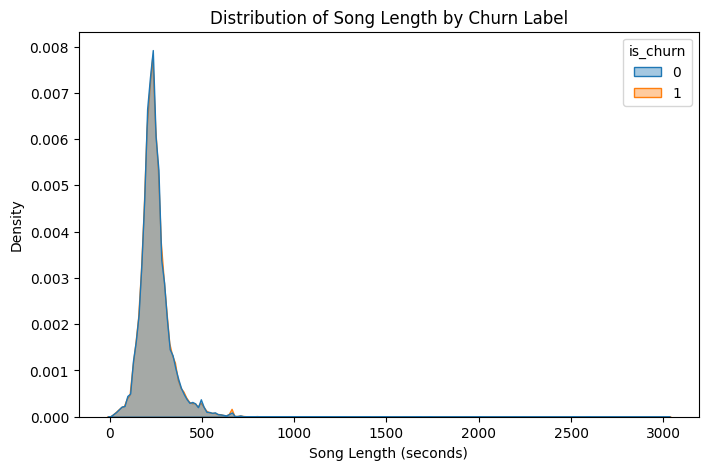

In [32]:
plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=train[train['length'].notnull()],
    x="length",
    hue="is_churn",
    common_norm=False,
    fill=True,
    alpha=0.4
)
plt.title("Distribution of Song Length by Churn Label")
plt.xlabel("Song Length (seconds)")
plt.ylabel("Density")
plt.show()


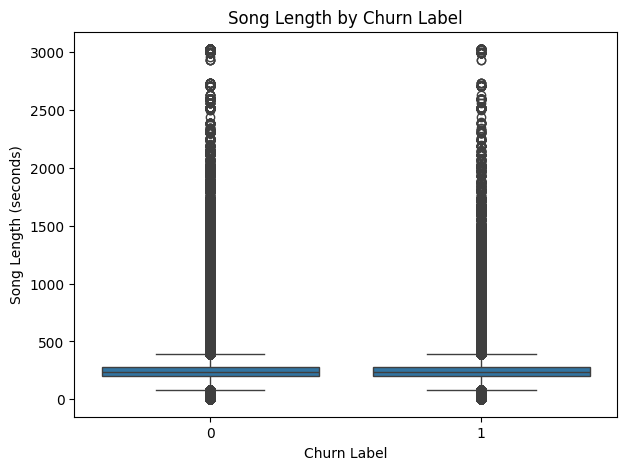

In [33]:
plt.figure(figsize=(7, 5))
sns.boxplot(
    data=train[train['length'].notnull()],
    x="is_churn",
    y="length"
)
plt.title("Song Length by Churn Label")
plt.xlabel("Churn Label")
plt.ylabel("Song Length (seconds)")
plt.show()

#### ItemInSession

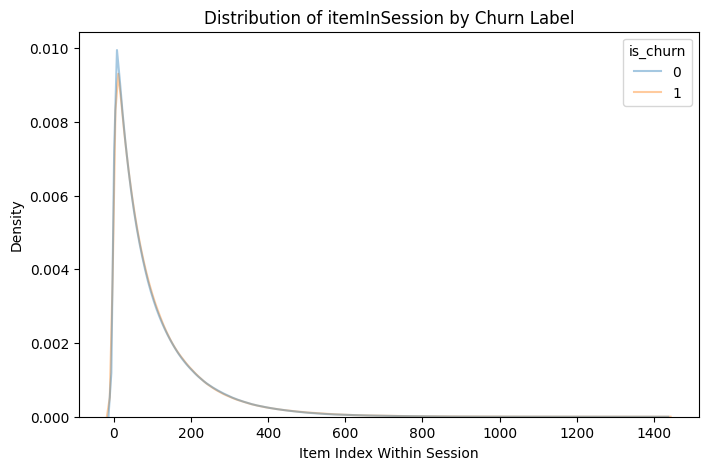

In [34]:
plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=train,
    x="itemInSession",
    hue="is_churn",
    common_norm=False,
    alpha=0.4
)
plt.title("Distribution of itemInSession by Churn Label")
plt.xlabel("Item Index Within Session")
plt.ylabel("Density")
plt.show()


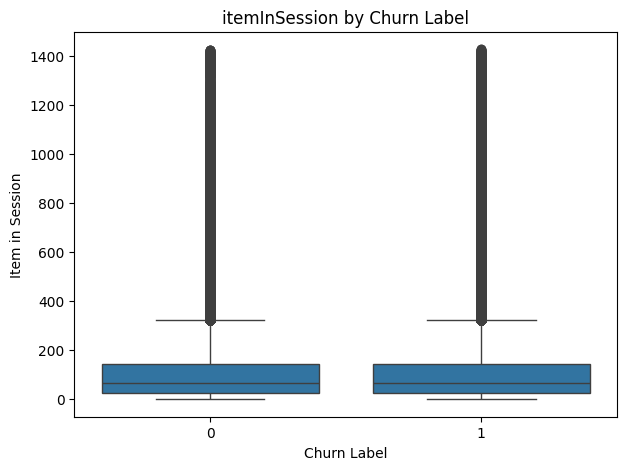

In [35]:
plt.figure(figsize=(7, 5))
sns.boxplot(
    data=train,
    x="is_churn",
    y="itemInSession"
)
plt.title("itemInSession by Churn Label")
plt.xlabel("Churn Label")
plt.ylabel("Item in Session")
plt.show()


#### User using pattern

In [45]:
train['hour'] = train['time'].dt.hour
train['dayofweek'] = train['time'].dt.dayofweek

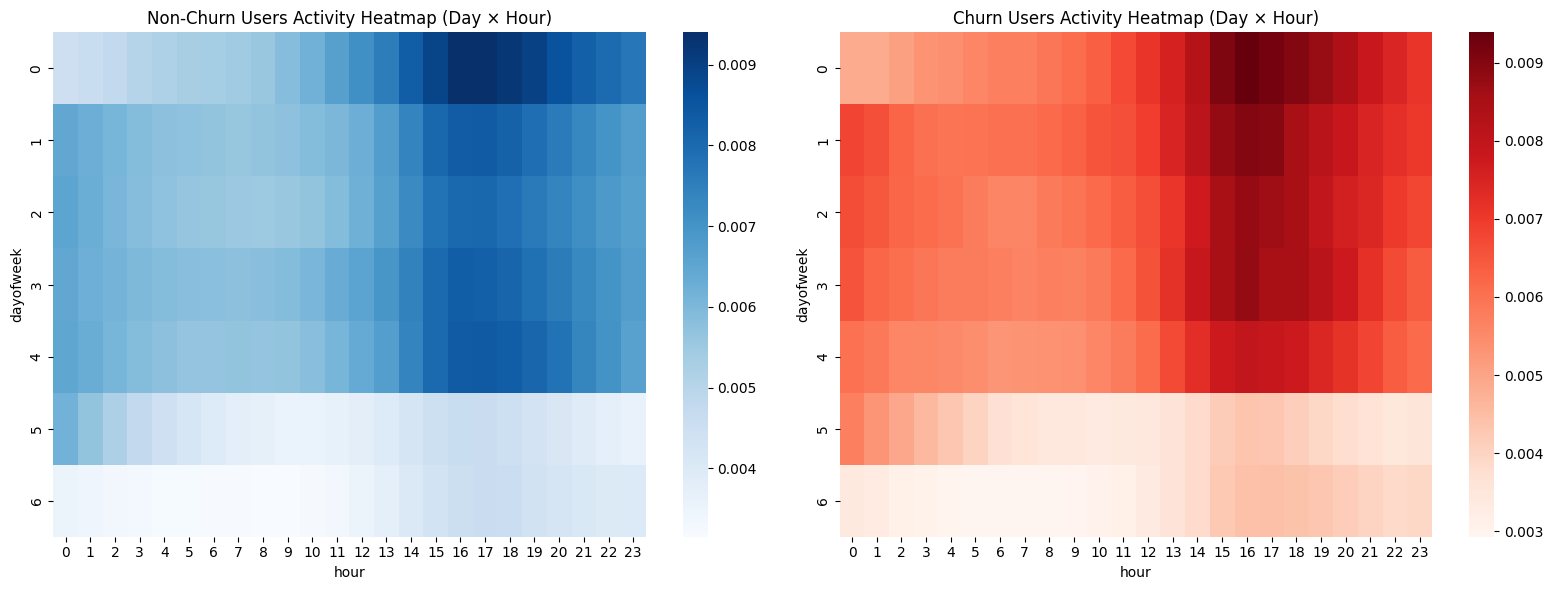

In [46]:
non_matrix = (
    train[train['is_churn'] == 0]
    .groupby(['dayofweek','hour'])
    .size()
    .unstack(fill_value=0)
)

non_norm = non_matrix / non_matrix.values.sum()

churn_matrix = (
    train[train['is_churn'] == 1]
    .groupby(['dayofweek','hour'])
    .size()
    .unstack(fill_value=0)
)

churn_norm = churn_matrix / churn_matrix.values.sum()

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(non_norm, cmap='Blues')
plt.title("Non-Churn Users Activity Heatmap (Day × Hour)")

plt.subplot(1, 2, 2)
sns.heatmap(churn_norm, cmap='Reds')
plt.title("Churn Users Activity Heatmap (Day × Hour)")

plt.tight_layout()
plt.show()

### User table transition

In [36]:
user_base = pd.DataFrame(index=duration.index)
user_base['duration_days'] = duration
user_base['session_count'] = sessions
user_base['total_events'] = user_total
user_base['target'] = user_base.index.isin(churn_users).astype(int)

user_base.head()


,duration_days,session_count,total_events,target
userId,,,,
1000025,100,17,2003,1
1000035,63,21,1556,0
1000083,34,11,594,1
1000103,47,3,75,0
1000164,99,15,1028,0


In [37]:
user_base['target'].value_counts(normalize=True)

target
0    0.776855
1    0.223145
Name: proportion, dtype: float64

### Creating user-base dataset

#### Adding created variables

In [38]:
page_feats = page_ratio.drop(columns=['target'])
user_base = user_base.join(page_feats, how='left')


#### Bringing existing features

In [39]:
gender = train.groupby('userId')['gender'].first()
user_base['gender'] = gender

In [40]:
last_level = train.sort_values(['userId', 'ts']).groupby('userId')['level'].last()
user_base['level'] = last_level

Adding level transition variables

To see if we can use the page "Submit upgrade" as a true transition variable

In [41]:
sample_users = np.random.choice(train['userId'].unique(), size=10, replace=False)

def true_transition_count(level_list):
    count = 0
    for i in range(1, len(level_list)):
        if level_list[i] != level_list[i-1]:
            count += 1
    return count

experiment_rows = []

for uid in sample_users:
    df_u = train[train['userId'] == uid].sort_values('ts')

    lvl_seq = df_u['level'].tolist()
    true_trans = true_transition_count(lvl_seq)
    
    upgrade = (df_u['page'] == 'Upgrade').sum()
    submit_upgrade = (df_u['page'] == 'Submit Upgrade').sum()
    downgrade = (df_u['page'] == 'Downgrade').sum()
    submit_downgrade = (df_u['page'] == 'Submit Downgrade').sum()
    
    experiment_rows.append({
        'userId': uid,
        'level_sequence': lvl_seq,
        'true_transition_count': true_trans,
        'upgrade': upgrade,
        'submit_upgrade': submit_upgrade,
        'downgrade': downgrade,
        'submit_downgrade': submit_downgrade
    })

experiment_df = pd.DataFrame(experiment_rows)


In [42]:
user_base['upgrade_count'] = page_counts['Upgrade']
user_base['submit_upgrade_count'] = page_counts['Submit Upgrade']
user_base['downgrade_count'] = page_counts['Downgrade']
user_base['submit_downgrade_count'] = page_counts['Submit Downgrade']

In [43]:
# Ratios
user_base['upgrade_ratio'] = user_base['upgrade_count'] / user_base['total_events']
user_base['submit_upgrade_ratio'] = user_base['submit_upgrade_count'] / user_base['total_events']
user_base['downgrade_ratio'] = user_base['downgrade_count'] / user_base['total_events']
user_base['submit_downgrade_ratio'] = user_base['submit_downgrade_count'] / user_base['total_events']


### Adding new variables

In [ ]:
# Time gap features
train_sorted = train.sort_values(['userId', 'ts'])
ts_diff = train_sorted.groupby('userId')['ts'].diff()
gap_hours = ts_diff / 1000 / 3600
mask = gap_hours > 0
mean_gap = gap_hours[mask].groupby(train_sorted['userId'][mask]).mean()
median_gap = gap_hours[mask].groupby(train_sorted['userId'][mask]).median()
user_base['mean_gap_hours'] = mean_gap
user_base['median_gap_hours'] = median_gap